# OPT -> Etape de modélisation : 

Le but de cette étape est d'utiliser un algorithme de machine learning qui va essayer de prédire les tendences du marché en se basant sur les données historiques . 

Cette étape de modélisation vient aprés une étape de collecte de données via l'API binance. Pour récupérer ces données collectés on va établir une liaison avec la base de données préalablement dockerisée . 


In [35]:
#to know which environment we are working in 
import sys
print(sys.executable)


C:\Users\hamza\anaconda3\python.exe


In [14]:
# import mysql.connector

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


%matplotlib inline

## Connexion avec la base  de données Mysql : 


In [3]:
cnx = mysql.connector.connect(user='root', password='temp123',
                              host=' 0.0.0.0', port='3306',
                              database='opa')
## remplacer host par l'ID de votre machine virtuelle 
## port : représente le port ou elle est logée notre DB sur le docker 
cursor = cnx.cursor()

# Execute a query to retrieve data from a table
query = "SELECT * FROM historical_klines"
cursor.execute(query)

# Load the data into a Pandas DataFrame
data = pd.DataFrame(cursor.fetchall(), columns=['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'close_time', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'])
display(data.head())

cursor.close()
cnx.close()

,id_symint,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181000,1502945999999,202366.0,171.0,35.160500,150952.00
1,1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234900,1502949599999,100305.0,102.0,21.448100,92608.30
2,1,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229690,1502953199999,31282.3,36.0,4.802860,20795.30
3,1,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443250,1502956799999,19241.1,25.0,2.602290,11291.30
4,1,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.5,28.0,0.814655,3552.75


In [4]:
data=pd.read_csv('data.csv')

In [5]:
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data = data.set_index('close_time')
data.sort_index(inplace = True)
data.columns

Index(['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],
      dtype='object')

## Modélisation : 

Pour l'étape de modélisation on a testé trois approches : 
* Un modéle de régression : avec les forêts aléatoires(Random Forest Regressor) avec comme variable target close price 
* Un modèle de classification : avec les forêts aléatoires( Random Forest Classifier) avec comme variable target 'is_profit qui prend True si l’action a atteint l’objectif de profit de 1% , False dans le cas contraire. 
* Les séries temporelles : on a testé les modèles d'ARIMA , ARIMAX 

### 1. Random Forest Regressor : 

In [6]:
#fill any missing values
data = data.ffill()
# Drop any rows with missing values
data.dropna(inplace=True)

#Ce code crée six colonnes décalées pour chacune des colonnes spécifiées dans lag_columns. La variable lag_count détermine le nombre de colonnes décalées à créer. La boucle for imbriquée parcourt chaque colonne et crée les colonnes décalées en utilisant la méthode shift(). Enfin, la fonction dropna() supprime les lignes avec des valeurs manquantes résultant du décalage.

In [7]:
##Create lagged features for the Random Forest model for each column 

lag_columns = ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 
               'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 
               'taker_buy_quote_asset_volume']

lag_count = 6

for col in lag_columns:
    for lag in range(1, lag_count + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

# Supprimer les lignes avec des valeurs manquantes après la création des colonnes décalées
data.dropna(inplace=True)


In [8]:
# Récupérer les noms de colonnes
column_names = data.columns

# Afficher les noms de colonnes avec une numérotation
for idx, col_name in enumerate(column_names, 1):
    print(f"{idx}. {col_name}")

1. id_symint
2. open_time
3. open_price
4. high_price
5. low_price
6. close_price
7. volume
8. quote_asset_volume
9. number_of_trades
10. taker_buy_base_asset_volume
11. taker_buy_quote_asset_volume
12. open_price_lag1
13. open_price_lag2
14. open_price_lag3
15. open_price_lag4
16. open_price_lag5
17. open_price_lag6
18. high_price_lag1
19. high_price_lag2
20. high_price_lag3
21. high_price_lag4
22. high_price_lag5
23. high_price_lag6
24. low_price_lag1
25. low_price_lag2
26. low_price_lag3
27. low_price_lag4
28. low_price_lag5
29. low_price_lag6
30. close_price_lag1
31. close_price_lag2
32. close_price_lag3
33. close_price_lag4
34. close_price_lag5
35. close_price_lag6
36. volume_lag1
37. volume_lag2
38. volume_lag3
39. volume_lag4
40. volume_lag5
41. volume_lag6
42. quote_asset_volume_lag1
43. quote_asset_volume_lag2
44. quote_asset_volume_lag3
45. quote_asset_volume_lag4
46. quote_asset_volume_lag5
47. quote_asset_volume_lag6
48. number_of_trades_lag1
49. number_of_trades_lag2
50. n

In [9]:
# Supprimer les colonnes indésirables pour les fonctionnalités
feats = data.drop(['close_price', 'id_symint', 'open_time'], axis=1)

# Utiliser la colonne 'close_price' comme cible
target = data['close_price']

# Pourcentage des données à utiliser pour l'ensemble de test (par exemple, 20%)
test_size = 0.2

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=test_size, random_state=42)

In [10]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer une instance du modèle RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Créer une instance de GridSearchCV pour rechercher les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Effectuer la recherche des meilleurs hyperparamètres en utilisant la validation croisée
grid_search.fit(X_train, y_train)

# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_

print("Best model parameters: ", grid_search.best_params_)
print("Best model MSE: ", -grid_search.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best model parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best model MSE:  7607107.264949279


In [11]:
import pickle

# Assuming your trained model is named `model`
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)


In [16]:
# Faire des prédictions sur les ensembles d'entraînement et de test
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Calculer les métriques d'évaluation (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"RMSE pour l'ensemble d'entraînement: {train_rmse}")
print(f"RMSE pour l'ensemble de test: {test_rmse}")

# Tracer les prédictions


RMSE pour l'ensemble d'entraînement: 48.27857681964055
RMSE pour l'ensemble de test: 48.48715614740078


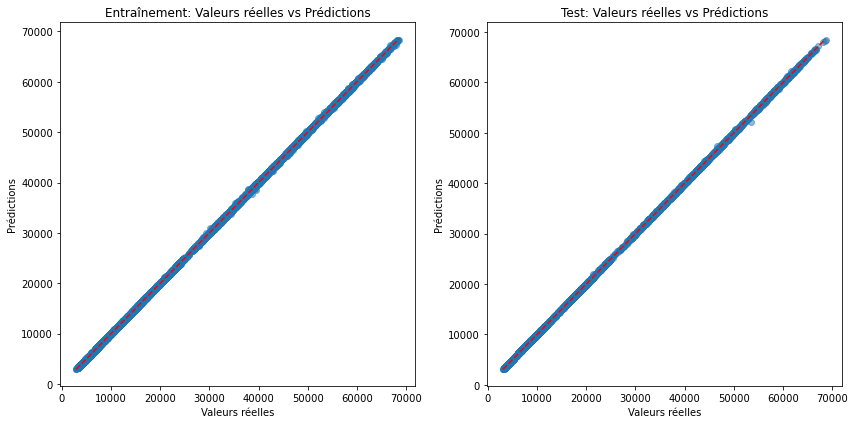

In [29]:
# Créer un DataFrame pour stocker les prédictions et les valeurs réelles
train_results = pd.DataFrame({'Actual': y_train, 'Predicted': train_preds})
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': test_preds})

# Créer un graphique pour comparer les prédictions et les valeurs réelles
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_results['Actual'], train_results['Predicted'], alpha=0.5)
plt.plot([min(train_results['Actual']), max(train_results['Actual'])], [min(train_results['Actual']), max(train_results['Actual'])], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Entraînement: Valeurs réelles vs Prédictions')

plt.subplot(1, 2, 2)
plt.scatter(test_results['Actual'], test_results['Predicted'], alpha=0.5)
plt.plot([min(test_results['Actual']), max(test_results['Actual'])], [min(test_results['Actual']), max(test_results['Actual'])], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Test: Valeurs réelles vs Prédictions')

plt.tight_layout()
plt.show()


In [33]:
# Plot the actual and predicted close prices for the last 24 hours
last_24_hours = data.iloc[-24:]
actual_close_prices = last_24_hours['close_price']
predicted_close_prices = pd.Series(best_model.predict(feats[-24:]), index=last_24_hours.index)

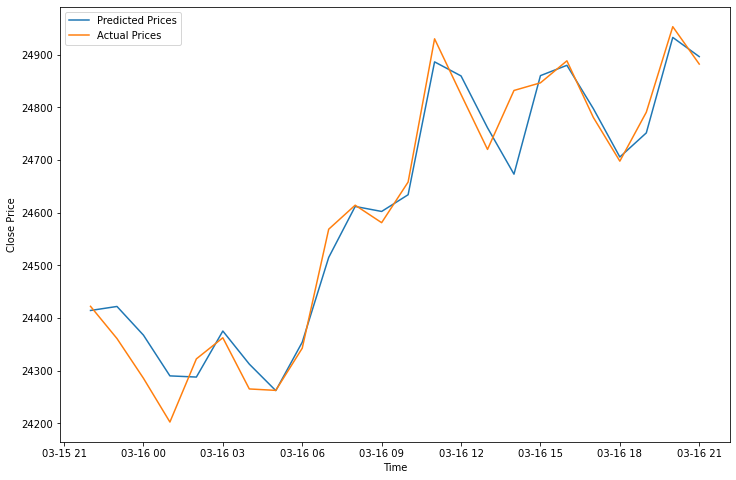

In [34]:
df_actual_prices = pd.DataFrame(actual_close_prices)
df_predicted_prices = pd.DataFrame(predicted_close_prices)
df_predicted_prices.rename(columns={0:"predicted_close_prices"}, inplace=True)
plt.figure(figsize=(12,8))

plt.plot(df_predicted_prices , label='Predicted Prices')
plt.plot(df_actual_prices , label='Actual Prices')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()


plt.show()